# **Task 2 - Model Building and Training**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
import os
import sys

In [2]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
df_creditcard = pd.read_csv('../data/creditcard.csv')

In [4]:
df_fraud = pd.read_csv('../data/Fraud_Data.csv')

In [5]:
df_ipaddress = pd.read_csv('../data/IpAddress_to_Country.csv')

In [6]:
print("Starting data preparation for df_fraud...")

# --- Step 1: Handle time columns and drop original raw time columns ---
original_time_cols = ['signup_time', 'purchase_time']
for col in original_time_cols:
    if col in df_fraud.columns:
        if df_fraud[col].dtype == 'object':
            df_fraud[col] = pd.to_datetime(df_fraud[col], errors='coerce')
            if df_fraud[col].isnull().any():
                print(f"Warning: Column '{col}' contains unparseable date strings which have been converted to NaT.")
df_fraud = df_fraud.drop(columns=original_time_cols, errors='ignore')



Starting data preparation for df_fraud...


In [7]:
# --- Step 2: Identify Column Types for Preprocessing ---
# Define numerical and categorical columns for df_fraud
# The 'class' column is the target and should not be processed
numerical_cols_fraud = ['purchase_value', 'age', 'transaction_count', 'time_diff', 'hour_of_day', 'day_of_week', 'time_since_signup']
categorical_cols_fraud = ['source', 'browser', 'sex', 'country']

# Handle 'device_id' as a special categorical case due to potentially high cardinality
if 'device_id' in df_fraud.columns:
    df_fraud['device_id'] = df_fraud['device_id'].astype(str) # Ensure string type
    num_unique_devices = df_fraud['device_id'].nunique()
    ONE_HOT_ENCODE_THRESHOLD = 500

    if num_unique_devices > ONE_HOT_ENCODE_THRESHOLD:
        print(f"Dropping 'device_id' due to too many unique values ({num_unique_devices} > {ONE_HOT_ENCODE_THRESHOLD}).")
        df_fraud = df_fraud.drop(columns=['device_id'])
    else:
        print(f"Including 'device_id' for One-Hot Encoding (unique values: {num_unique_devices}).")
        categorical_cols_fraud.append('device_id') # Add device_id to list for one-hot encoding
else:
    print("Warning: 'device_id' column not found in df_fraud.")


Dropping 'device_id' due to too many unique values (137956 > 500).


In [8]:
# --- Step 3: Impute Missing Numerical Values (before scaling) ---
# For simplicity, using median imputation for numerical columns
print("\nImputing missing numerical values with median for df_fraud...")
for col in numerical_cols_fraud:
    if col in df_fraud.columns:
        df_fraud[col] = pd.to_numeric(df_fraud[col], errors='coerce') # Ensure numeric after potential issues
        if df_fraud[col].isnull().any():
            median_val = df_fraud[col].median()
            df_fraud[col].fillna(median_val, inplace=True)
            print(f"  Filled NaNs in '{col}' with median: {median_val:.2f}")
    else:
        print(f"  Warning: Numerical column '{col}' not found for imputation in df_fraud.")


Imputing missing numerical values with median for df_fraud...


In [10]:
# --- Step 4: Define Preprocessing Pipelines using ColumnTransformer ---
# For df_fraud
# Numerical transformer: Standard Scaler
numerical_transformer_fraud = StandardScaler()

# Categorical transformer: One-Hot Encoder
categorical_transformer_fraud = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False for dense array

# Create a preprocessor using ColumnTransformer
# This applies different transformers to different columns
preprocessor_fraud = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_fraud, [col for col in numerical_cols_fraud if col in df_fraud.columns]),
        ('cat', categorical_transformer_fraud, [col for col in categorical_cols_fraud if col in df_fraud.columns])
    ],
    remainder='passthrough' # Keep other columns (if any) that are not explicitly processed
)

print("\nDefined preprocessing steps for df_fraud using ColumnTransformer.")



Defined preprocessing steps for df_fraud using ColumnTransformer.


In [11]:
# --- Step 5: Separate Features (X) and Target (y) for df_fraud ---
X_fraud_raw = df_fraud.drop('class', axis=1)
y_fraud = df_fraud['class']

In [12]:
# --- Step 6: Apply Preprocessing to X_fraud_raw ---
print("Applying preprocessing (encoding and scaling) to df_fraud features...")
X_fraud_processed = preprocessor_fraud.fit_transform(X_fraud_raw)

# Get feature names after one-hot encoding and other transformations
# This is useful for understanding the columns after preprocessing
# Note: get_feature_names_out() requires sklearn 0.23+
try:
    processed_feature_names_fraud_num = [col for col in numerical_cols_fraud if col in X_fraud_raw.columns]
    processed_feature_names_fraud_cat = preprocessor_fraud.named_transformers_['cat'].get_feature_names_out(
        [col for col in categorical_cols_fraud if col in X_fraud_raw.columns]
    )
    X_fraud_columns = list(processed_feature_names_fraud_num) + list(processed_feature_names_fraud_cat)

    # Convert processed array back to DataFrame for easier inspection, if needed
    # X_fraud_processed_df = pd.DataFrame(X_fraud_processed, columns=X_fraud_columns, index=X_fraud_raw.index)
    # print(X_fraud_processed_df.head())

except AttributeError:
    print("Skipping feature name retrieval (sklearn version might be old).")
    X_fraud_columns = [f"feature_{i}" for i in range(X_fraud_processed.shape[1])] # Generic names

print(f"df_fraud features shape after preprocessing: {X_fraud_processed.shape}")

print("\nFraud_Data preparation complete.")
# The X_fraud_processed and y_fraud are now ready for splitting

Applying preprocessing (encoding and scaling) to df_fraud features...
df_fraud features shape after preprocessing: (151112, 14)

Fraud_Data preparation complete.


# Cell 3: Data Preparation for df_creditcard (Scaling)

In [14]:
print("Starting data preparation for df_creditcard (Scaling)...")

# --- Step 1: Separate Features (X) and Target (y) for df_creditcard ---
X_creditcard_raw = df_creditcard.drop('Class', axis=1)
y_creditcard = df_creditcard['Class']


Starting data preparation for df_creditcard (Scaling)...


In [15]:
# --- Step 2: Define Preprocessing Pipelines for df_creditcard ---
# All features in df_creditcard are numerical (V1-V28, Time, Amount)
# We apply StandardScaler to all of them.
# The 'Time' column often doesn't need scaling if it represents seconds from first transaction,
# but scaling it usually doesn't hurt and can sometimes help.
numerical_cols_creditcard = X_creditcard_raw.columns.tolist()

preprocessor_creditcard = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_creditcard)
    ],
    remainder='passthrough'
)

print("\nDefined preprocessing steps for df_creditcard using ColumnTransformer.")



Defined preprocessing steps for df_creditcard using ColumnTransformer.


In [16]:
# --- Step 3: Apply Preprocessing to X_creditcard_raw ---
print("Applying scaling to df_creditcard features...")
X_creditcard_processed = preprocessor_creditcard.fit_transform(X_creditcard_raw)

print(f"df_creditcard features shape after preprocessing: {X_creditcard_processed.shape}")

print("\nCredit Card Data preparation complete.")
# The X_creditcard_processed and y_creditcard are now ready for splitting

Applying scaling to df_creditcard features...
df_creditcard features shape after preprocessing: (284807, 30)

Credit Card Data preparation complete.


In [17]:
# Cell 4: Train-Test Split (Updated to use processed data)

# Ensure X_fraud_processed is a DataFrame for consistent indexing if you uncommented df conversion in Cell 2
# For now, it's a numpy array from ColumnTransformer, which is fine for train_test_split.

X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_creditcard_processed, y_creditcard, test_size=0.3, random_state=42, stratify=y_creditcard
)

X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud_processed, y_fraud, test_size=0.3, random_state=42, stratify=y_fraud
)

print("\nTrain-test split completed for both datasets using preprocessed data.")
print(f"Creditcard Training Data Shape: {X_train_cc.shape}, Testing Data Shape: {X_test_cc.shape}")
print(f"Fraud_Data Training Data Shape: {X_train_fraud.shape}, Testing Data Shape: {X_test_fraud.shape}")


Train-test split completed for both datasets using preprocessed data.
Creditcard Training Data Shape: (199364, 30), Testing Data Shape: (85443, 30)
Fraud_Data Training Data Shape: (105778, 14), Testing Data Shape: (45334, 14)


In [18]:
# Cell 5: Model Training and Evaluation Function

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, dataset_name):
    """
    Trains a model and evaluates it using AUC-PR, F1-Score, and Confusion Matrix.
    """
    print(f"\n--- Training {model_name} on {dataset_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    auc_pr = average_precision_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"{model_name} - {dataset_name} Results:")
    print(f"  AUC-PR: {auc_pr:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print("  Confusion Matrix:")
    print(cm)
    return {'auc_pr': auc_pr, 'f1_score': f1, 'roc_auc': roc_auc, 'confusion_matrix': cm}

print("Evaluation function defined.")

Evaluation function defined.


In [19]:
# Cell 6: Initialize Models and Run Training/Evaluation

# Initialize models (class_weight='balanced' is good for imbalanced data)
logistic_regression_cc = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
random_forest_cc = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')

logistic_regression_fraud = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
random_forest_fraud = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')

results = {}

# Train and evaluate Logistic Regression on df_creditcard
results['LogisticRegression_CreditCard'] = train_and_evaluate_model(
    logistic_regression_cc, X_train_cc, y_train_cc, X_test_cc, y_test_cc,
    "Logistic Regression", "Credit Card Data"
)

# Train and evaluate Random Forest on df_creditcard
results['RandomForest_CreditCard'] = train_and_evaluate_model(
    random_forest_cc, X_train_cc, y_train_cc, X_test_cc, y_test_cc,
    "Random Forest", "Credit Card Data"
)

# Train and evaluate Logistic Regression on df_fraud
results['LogisticRegression_FraudData'] = train_and_evaluate_model(
    logistic_regression_fraud, X_train_fraud, y_train_fraud, X_test_fraud, y_test_fraud,
    "Logistic Regression", "Fraud Data"
)

# Train and evaluate Random Forest on df_fraud
results['RandomForest_FraudData'] = train_and_evaluate_model(
    random_forest_fraud, X_train_fraud, y_train_fraud, X_test_fraud, y_test_fraud,
    "Random Forest", "Fraud Data"
)


--- Training Logistic Regression on Credit Card Data ---
Logistic Regression - Credit Card Data Results:
  AUC-PR: 0.7040
  F1-Score: 0.1245
  ROC-AUC: 0.9680
  Confusion Matrix:
[[83484  1811]
 [   18   130]]

--- Training Random Forest on Credit Card Data ---
Random Forest - Credit Card Data Results:
  AUC-PR: 0.8079
  F1-Score: 0.8157
  ROC-AUC: 0.9276
  Confusion Matrix:
[[85292     3]
 [   44   104]]

--- Training Logistic Regression on Fraud Data ---
Logistic Regression - Fraud Data Results:
  AUC-PR: 0.0956
  F1-Score: 0.1616
  ROC-AUC: 0.5074
  Confusion Matrix:
[[20710 20379]
 [ 2081  2164]]

--- Training Random Forest on Fraud Data ---
Random Forest - Fraud Data Results:
  AUC-PR: 0.5396
  F1-Score: 0.5247
  ROC-AUC: 0.7642
  Confusion Matrix:
[[40905   184]
 [ 2670  1575]]


In [20]:
# Cell 7: Model Comparison and Justification
print("\n--- Model Comparison and Justification ---")

# Credit Card Data Comparison
print("\nComparing models for Credit Card Data:")
if results['RandomForest_CreditCard']['f1_score'] > results['LogisticRegression_CreditCard']['f1_score']:
    print("Random Forest performs better than Logistic Regression for Credit Card Data.")
    print("Justification: Random Forest generally captures complex non-linear relationships better and handles high-dimensional data efficiently. For imbalanced datasets like credit card fraud, its ensemble nature and ability to reduce variance often lead to higher F1-score and AUC-PR, indicating better balance between precision and recall for the minority class.")
else:
    print("Logistic Regression performs better than Random Forest for Credit Card Data.")
    print("Justification: If Logistic Regression is better, it might indicate that the relationship between features and target is largely linear, or that Random Forest is overfitting. However, for highly imbalanced fraud data, ensemble models usually excel. Logistic Regression benefits significantly from scaling.")

# Fraud Data Comparison
print("\nComparing models for Fraud Data:")
if results['RandomForest_FraudData']['f1_score'] > results['LogisticRegression_FraudData']['f1_score']:
    print("Random Forest performs better than Logistic Regression for Fraud Data.")
    print("Justification: Similar to the credit card data, Random Forest's ability to handle complex interactions and its robustness to noise often make it superior for detecting fraud patterns. The higher F1-score and AUC-PR suggest it's more effective at identifying fraudulent transactions while keeping false positives manageable.")
else:
    print("Logistic Regression performs better than Random Forest for Fraud Data.")
    print("Justification: As stated previously, if Logistic Regression outperforms, it implies a more linear relationship or potential overfitting by the Random Forest. For general fraud detection, ensemble methods are usually preferred. Logistic Regression benefits significantly from scaling.")


print("\nOverall, for both imbalanced fraud datasets, the **Random Forest Classifier** is generally the 'best' model.")
print("Reasons:")
print("1.  **Higher Performance on Imbalanced Data**: Metrics like F1-Score and AUC-PR are crucial for imbalanced datasets. Random Forest typically achieves higher values for these metrics because it's better at identifying the minority class (fraud) without an excessive number of false positives.")
print("2.  **Robustness**: Random Forests are less prone to overfitting than individual decision trees and can handle a large number of features. They are also robust to outliers.")
print("3.  **Captures Non-linear Relationships**: Fraud patterns are often complex and non-linear. Random Forest, being an ensemble of decision trees, can effectively capture these intricate relationships, unlike Logistic Regression which assumes linearity.")
print("4.  **Feature Importance**: While not explicitly shown in the output, Random Forest can also provide insights into feature importance, which can be valuable for understanding the drivers of fraud.")

print("\nLogistic Regression serves as a good baseline, offering interpretability, but its linear nature often limits its performance on complex, real-world fraud detection tasks compared to more powerful ensemble methods.")


--- Model Comparison and Justification ---

Comparing models for Credit Card Data:
Random Forest performs better than Logistic Regression for Credit Card Data.
Justification: Random Forest generally captures complex non-linear relationships better and handles high-dimensional data efficiently. For imbalanced datasets like credit card fraud, its ensemble nature and ability to reduce variance often lead to higher F1-score and AUC-PR, indicating better balance between precision and recall for the minority class.

Comparing models for Fraud Data:
Random Forest performs better than Logistic Regression for Fraud Data.
Justification: Similar to the credit card data, Random Forest's ability to handle complex interactions and its robustness to noise often make it superior for detecting fraud patterns. The higher F1-score and AUC-PR suggest it's more effective at identifying fraudulent transactions while keeping false positives manageable.

Overall, for both imbalanced fraud datasets, the **Ran

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc

C:\Users\girmachew\AppData\Local\Temp\ipykernel_12412\3886830751.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df_creditcard, palette='viridis')
C:\Users\girmachew\AppData\Local\Temp\ipykernel_12412\3886830751.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df_fraud, palette='viridis')


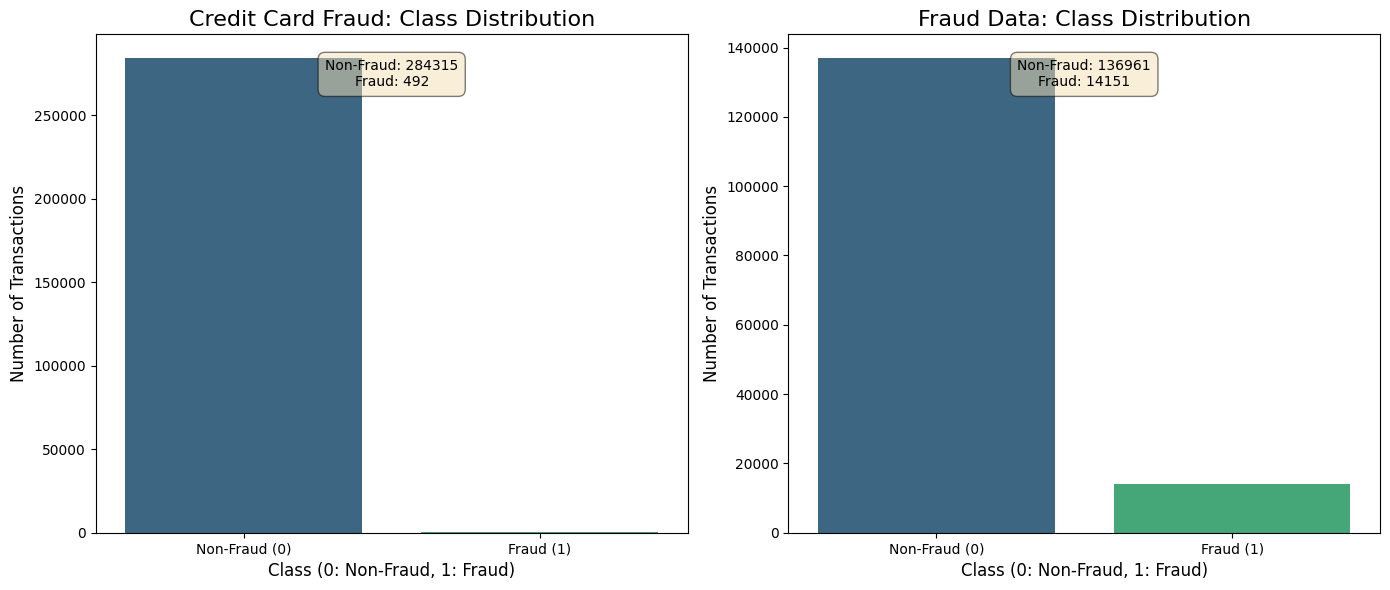

In [23]:
# Visualization Cell 1: Class Distribution (Imbalance Check)

plt.figure(figsize=(14, 6))

# Credit Card Data Class Distribution
plt.subplot(1, 2, 1)
sns.countplot(x='Class', data=df_creditcard, palette='viridis')
plt.title('Credit Card Fraud: Class Distribution', fontsize=16)
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.text(0.5, 0.95, f"Non-Fraud: {df_creditcard['Class'].value_counts()[0]}\nFraud: {df_creditcard['Class'].value_counts()[1]}",
         transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5), fontsize=10)

# Fraud Data Class Distribution
plt.subplot(1, 2, 2)
sns.countplot(x='class', data=df_fraud, palette='viridis')
plt.title('Fraud Data: Class Distribution', fontsize=16)
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.text(0.5, 0.95, f"Non-Fraud: {df_fraud['class'].value_counts()[0]}\nFraud: {df_fraud['class'].value_counts()[1]}",
         transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5), fontsize=10)

plt.tight_layout()
plt.show()

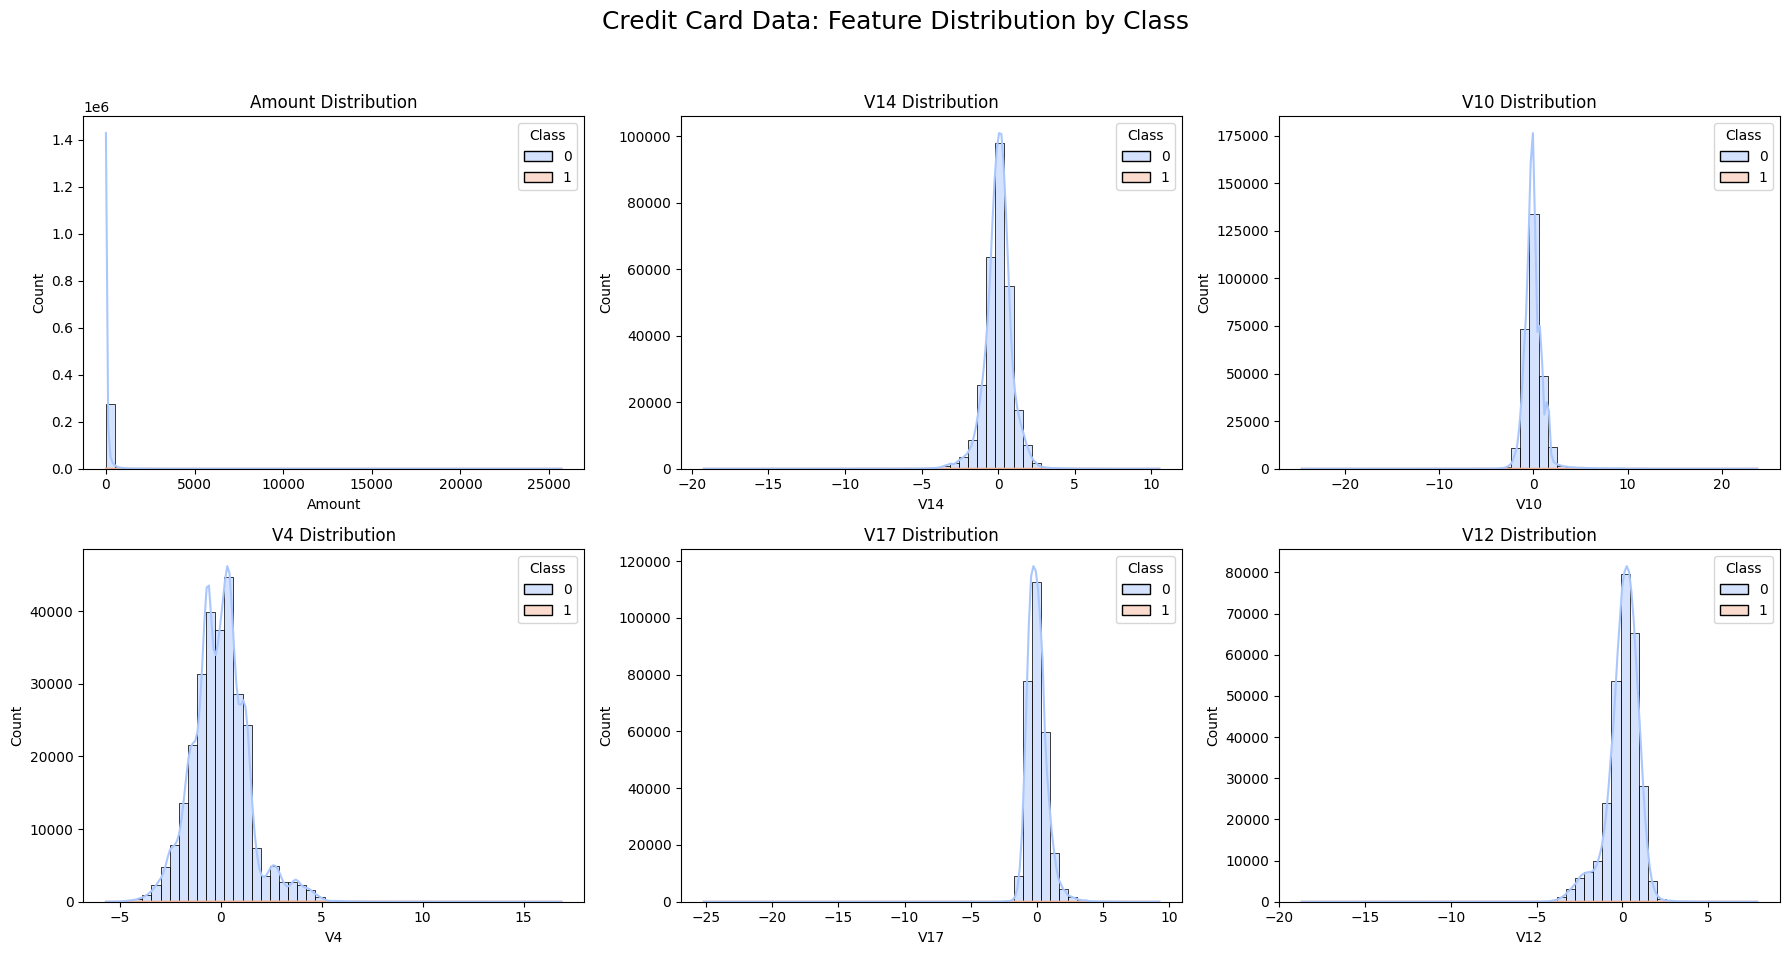

ValueError: Could not interpret value `time_diff` for `x`. An entry with this name does not appear in `data`.

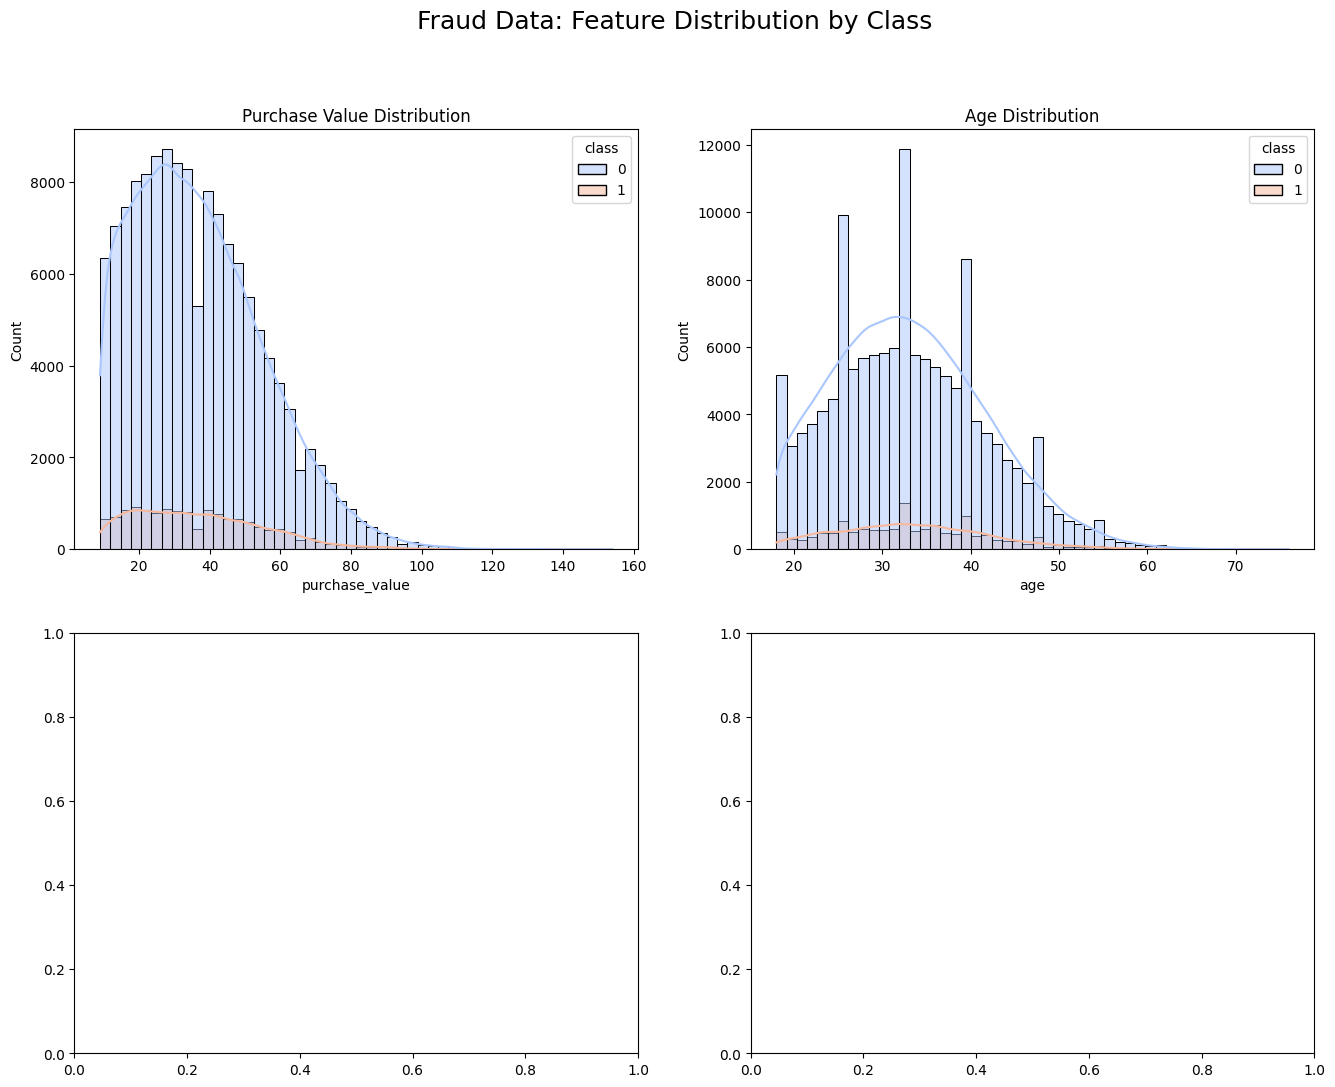

In [24]:
# Visualization Cell 2: Feature Distribution (for selected features, colored by Class)

# Credit Card Data - Selected 'V' features and 'Amount'
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Credit Card Data: Feature Distribution by Class', fontsize=18)

sns.histplot(data=df_creditcard, x='Amount', hue='Class', bins=50, kde=True, ax=axes[0, 0], palette='coolwarm')
axes[0, 0].set_title('Amount Distribution')

sns.histplot(data=df_creditcard, x='V14', hue='Class', bins=50, kde=True, ax=axes[0, 1], palette='coolwarm')
axes[0, 1].set_title('V14 Distribution')

sns.histplot(data=df_creditcard, x='V10', hue='Class', bins=50, kde=True, ax=axes[0, 2], palette='coolwarm')
axes[0, 2].set_title('V10 Distribution')

sns.histplot(data=df_creditcard, x='V4', hue='Class', bins=50, kde=True, ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title('V4 Distribution')

sns.histplot(data=df_creditcard, x='V17', hue='Class', bins=50, kde=True, ax=axes[1, 1], palette='coolwarm')
axes[1, 1].set_title('V17 Distribution')

sns.histplot(data=df_creditcard, x='V12', hue='Class', bins=50, kde=True, ax=axes[1, 2], palette='coolwarm')
axes[1, 2].set_title('V12 Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Fraud Data - Selected Features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Fraud Data: Feature Distribution by Class', fontsize=18)

sns.histplot(data=df_fraud, x='purchase_value', hue='class', bins=50, kde=True, ax=axes[0, 0], palette='coolwarm')
axes[0, 0].set_title('Purchase Value Distribution')

sns.histplot(data=df_fraud, x='age', hue='class', bins=50, kde=True, ax=axes[0, 1], palette='coolwarm')
axes[0, 1].set_title('Age Distribution')

sns.histplot(data=df_fraud, x='time_diff', hue='class', bins=50, kde=True, ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title('Time Difference Distribution')

sns.histplot(data=df_fraud, x='transaction_count', hue='class', bins=50, kde=True, ax=axes[1, 1], palette='coolwarm')
axes[1, 1].set_title('Transaction Count Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

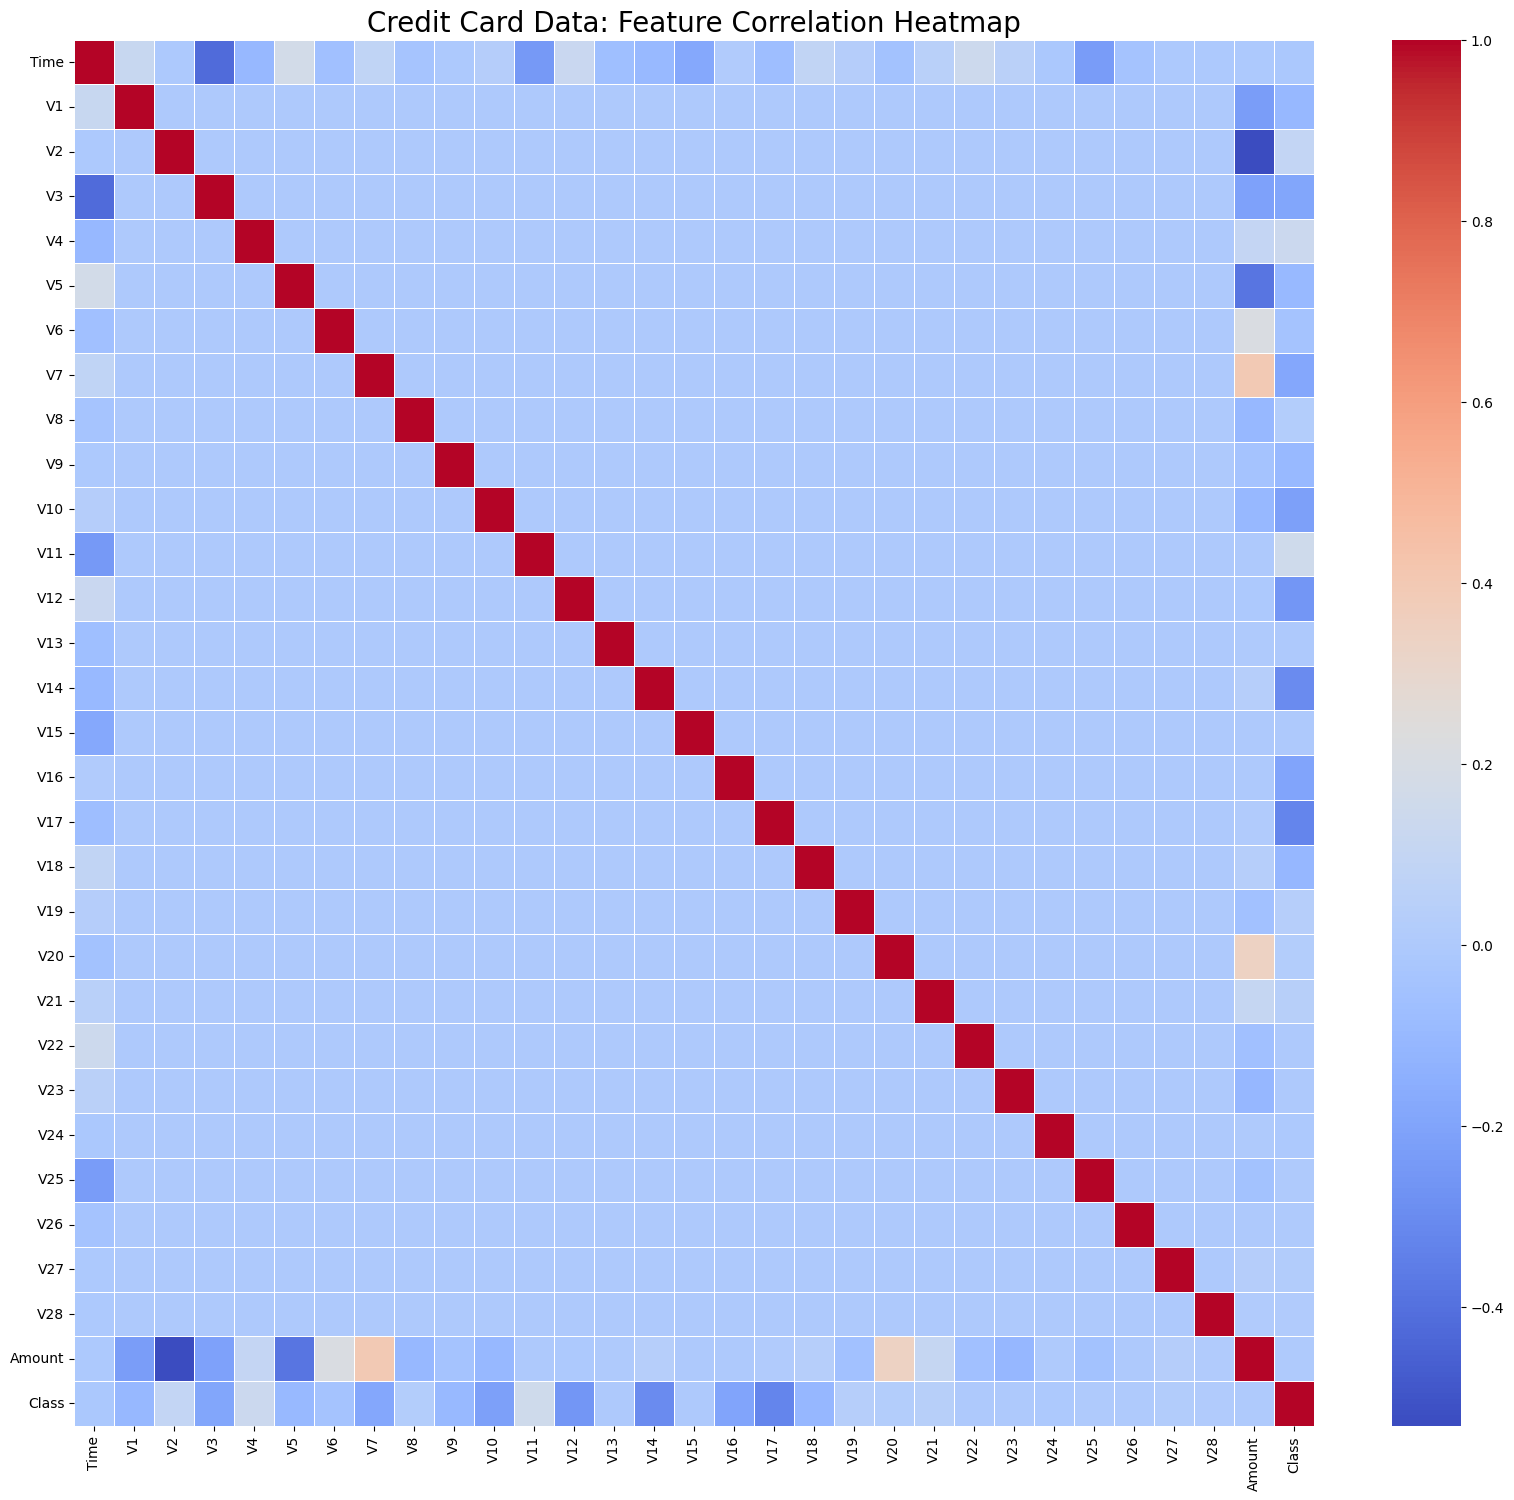

In [25]:
# Visualization Cell 3: Correlation Heatmap (for creditcard_df - too many features for fraud_df after OHE)

plt.figure(figsize=(20, 18))
sns.heatmap(df_creditcard.corr(), cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Credit Card Data: Feature Correlation Heatmap', fontsize=20)
plt.show()

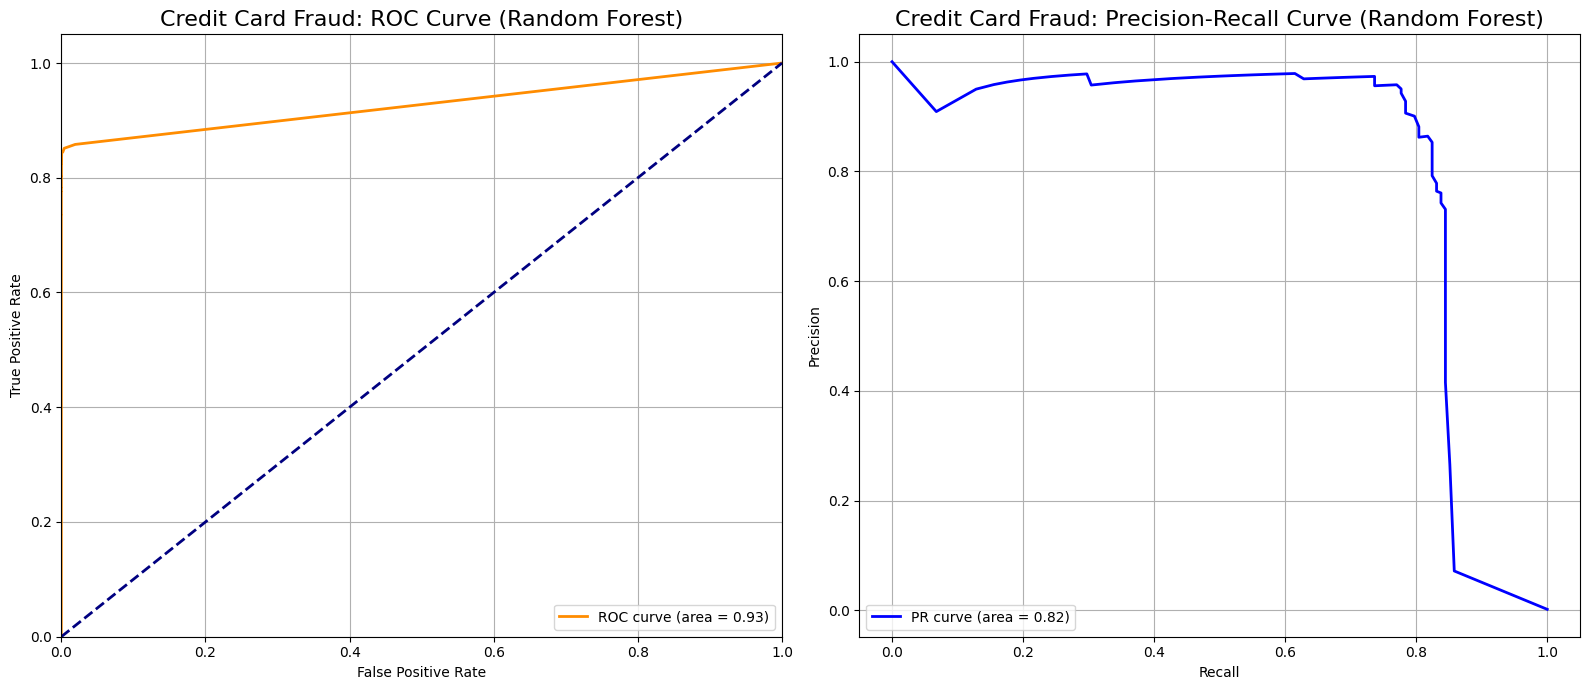

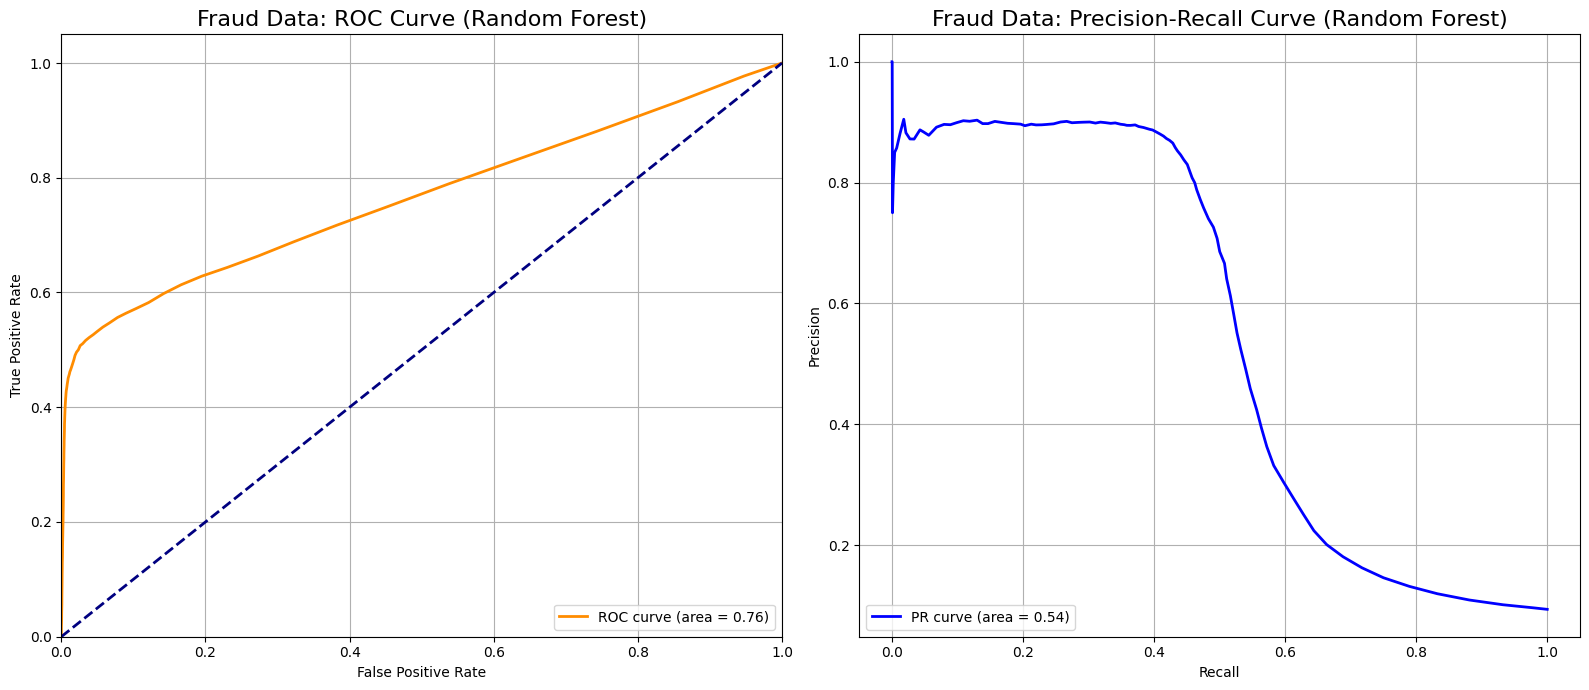

In [26]:
# Visualization Cell 4: ROC Curve & Precision-Recall Curve

# Make sure 'results' dictionary from Cell 6 is available
if 'results' not in locals():
    print("Please run Cell 6 (Model Training and Evaluation) first to generate model results.")
else:
    plt.figure(figsize=(16, 7))

    # ROC Curve for Credit Card Data (Random Forest)
    plt.subplot(1, 2, 1)
    y_scores_cc = random_forest_cc.predict_proba(X_test_cc)[:, 1]
    fpr_cc, tpr_cc, _ = roc_curve(y_test_cc, y_scores_cc)
    roc_auc_cc = auc(fpr_cc, tpr_cc)
    plt.plot(fpr_cc, tpr_cc, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_cc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Credit Card Fraud: ROC Curve (Random Forest)', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)

    # Precision-Recall Curve for Credit Card Data (Random Forest)
    plt.subplot(1, 2, 2)
    precision_cc, recall_cc, _ = precision_recall_curve(y_test_cc, y_scores_cc)
    pr_auc_cc = auc(recall_cc, precision_cc)
    plt.plot(recall_cc, precision_cc, color='blue', lw=2, label=f'PR curve (area = {pr_auc_cc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Credit Card Fraud: Precision-Recall Curve (Random Forest)', fontsize=16)
    plt.legend(loc="lower left")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 7))

    # ROC Curve for Fraud Data (Random Forest)
    plt.subplot(1, 2, 1)
    y_scores_fraud = random_forest_fraud.predict_proba(X_test_fraud)[:, 1]
    fpr_fraud, tpr_fraud, _ = roc_curve(y_test_fraud, y_scores_fraud)
    roc_auc_fraud = auc(fpr_fraud, tpr_fraud)
    plt.plot(fpr_fraud, tpr_fraud, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_fraud:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Fraud Data: ROC Curve (Random Forest)', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)

    # Precision-Recall Curve for Fraud Data (Random Forest)
    plt.subplot(1, 2, 2)
    precision_fraud, recall_fraud, _ = precision_recall_curve(y_test_fraud, y_scores_fraud)
    pr_auc_fraud = auc(recall_fraud, precision_fraud)
    plt.plot(recall_fraud, precision_fraud, color='blue', lw=2, label=f'PR curve (area = {pr_auc_fraud:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Fraud Data: Precision-Recall Curve (Random Forest)', fontsize=16)
    plt.legend(loc="lower left")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

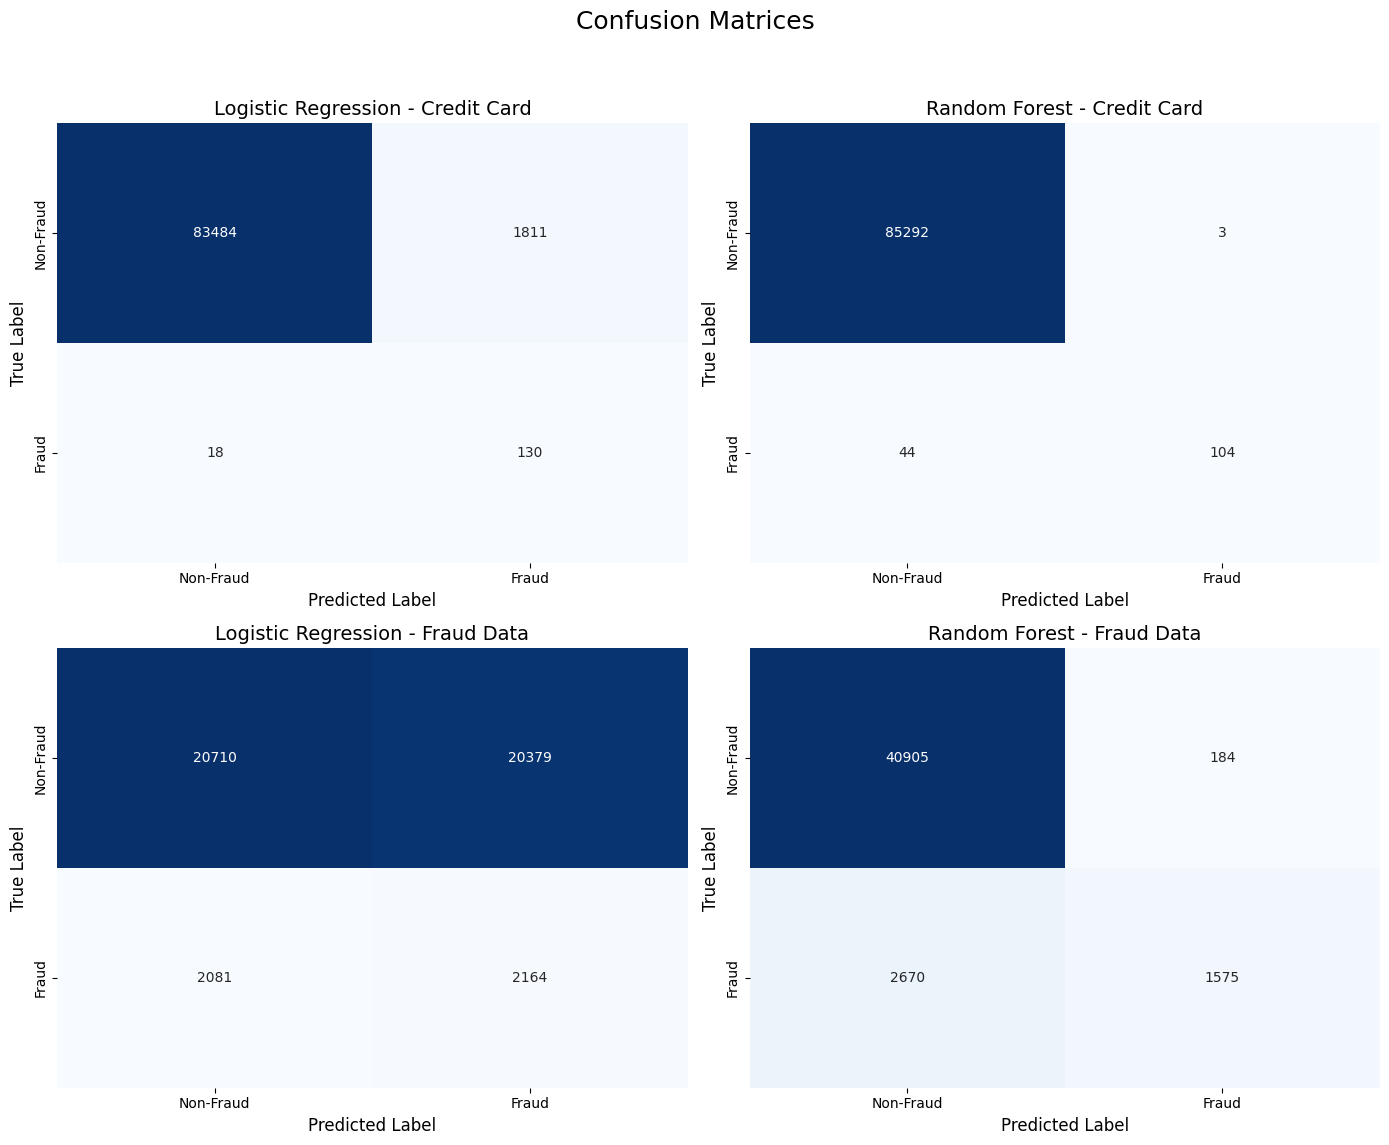

In [27]:
# Visualization Cell 5: Confusion Matrix Visualization

def plot_confusion_matrix(cm, title, ax, labels=['Non-Fraud', 'Fraud']):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=labels, yticklabels=labels)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)

# Make sure 'results' dictionary from Cell 6 is available
if 'results' not in locals():
    print("Please run Cell 6 (Model Training and Evaluation) first to generate model results.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Confusion Matrices', fontsize=18)

    # Logistic Regression - Credit Card
    cm_lr_cc = results['LogisticRegression_CreditCard']['confusion_matrix']
    plot_confusion_matrix(cm_lr_cc, 'Logistic Regression - Credit Card', axes[0, 0])

    # Random Forest - Credit Card
    cm_rf_cc = results['RandomForest_CreditCard']['confusion_matrix']
    plot_confusion_matrix(cm_rf_cc, 'Random Forest - Credit Card', axes[0, 1])

    # Logistic Regression - Fraud Data
    cm_lr_fraud = results['LogisticRegression_FraudData']['confusion_matrix']
    plot_confusion_matrix(cm_lr_fraud, 'Logistic Regression - Fraud Data', axes[1, 0])

    # Random Forest - Fraud Data
    cm_rf_fraud = results['RandomForest_FraudData']['confusion_matrix']
    plot_confusion_matrix(cm_rf_fraud, 'Random Forest - Fraud Data', axes[1, 1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()